### 앙상블 모델 ###

In [1]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

#데이터
df = pd.read_csv("Director_actor_encoding.csv")

# 예측: audiAcc (누적 관객 수)
target_column = "audiAcc"

# Feature 목록
features = [
    "pair_target_enc",
    "salesAmt", "audiCnt", "scrnCnt", "showCnt", "showTm"
]

# NaN 제거
data = pd.concat([df[features], df[target_column]], axis=1).dropna()
X = data[features]
y = data[target_column]

# 데이터 분할
# 20%의 데이터를 test set으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 앙상블 모델 구성
model1 = LGBMRegressor()
model2 = XGBRegressor()
model3 = CatBoostRegressor(verbose=0)

# Voting Regressor
voting_reg = VotingRegressor(estimators=[
    ("lgb", model1),
    ("xgb", model2),
    ("cat", model3)
])

# 학습 및 예측
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_test)

# 평가 지표 출력
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)


C:\Users\user\AppData\Local\Temp\ipykernel_16788\514842430.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Director_actor_encoding.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 25137, number of used features: 6
[LightGBM] [Info] Start training from score 1120457.077495
RMSE: 533285.9051196405
MAE: 204260.12177348454
R² Score: 0.9369438999453126


### LightGBM 기반 Feature Importance 분석 ###

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 25137, number of used features: 6
[LightGBM] [Info] Start training from score 1120457.077495


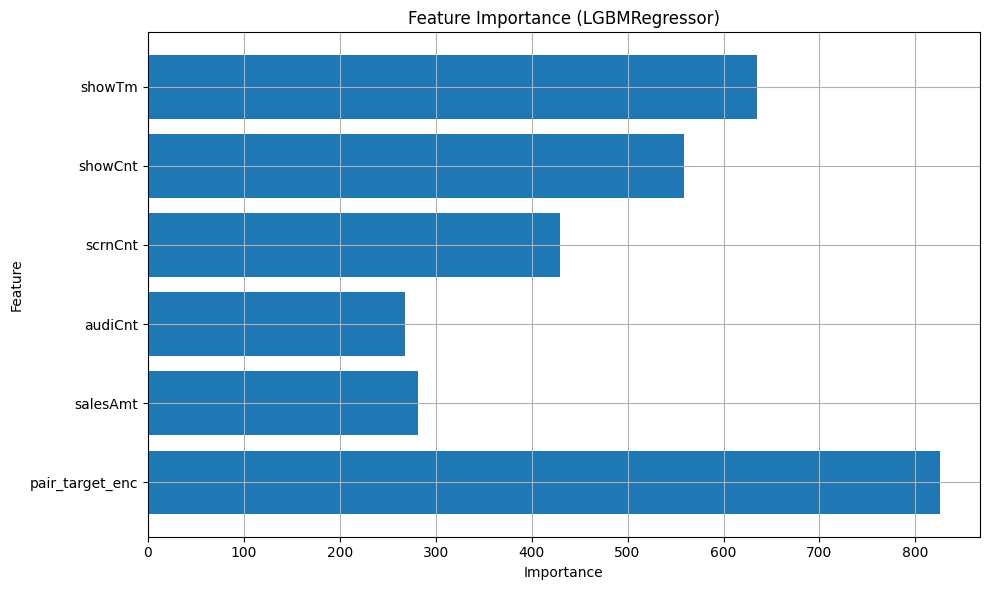

In [2]:
# 필요한 라이브러리 임포트
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# 1. 모델 정의 및 학습
model_lgb = LGBMRegressor()  # LightGBM 회귀 모델 생성
model_lgb.fit(X_train, y_train)  # 훈련 데이터로 모델 학습

# 2. 피처 중요도 추출
importances = model_lgb.feature_importances_  # 각 피처의 중요도
feature_names = X_train.columns  # 피처 이름

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)  # 수평 막대그래프로 시각화
plt.title("Feature Importance (LGBMRegressor)")  # 그래프 제목
plt.xlabel("Importance")  # x축 레이블
plt.ylabel("Feature")     # y축 레이블
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# 각 모델 fit() 호출
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 25137, number of used features: 6
[LightGBM] [Info] Start training from score 1120457.077495


### Shap

In [7]:
import shap
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 스케일링
scaler = StandardScaler()
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

# 각 모델별 매핑
model_dict = {
    "LGBM": model1,
    "XGBoost": model2,
    "CatBoost": model3
}

# 드롭다운
dropdown = widgets.Dropdown(
    options=list(model_dict.keys()),
    description='Model:',
    style={'description_width': 'initial'}
)

# 출력
def show_shap(model_name):
    model = model_dict[model_name]

    if model_name == "RandomForest":
        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    else:
        explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_test_scaled)
    shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
    plt.show()

# 인터랙션 연결
widgets.interact(show_shap, model_name=dropdown)

interactive(children=(Dropdown(description='Model:', options=('LGBM', 'XGBoost', 'CatBoost'), style=Descriptio…

<function __main__.show_shap(model_name)>

### Validation ###

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 25137, number of used features: 6
[LightGBM] [Info] Start training from score 1120457.077495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 25137, number of used features: 6
[LightGBM] [Info] Start training from score 1120160.537693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 25138, number of used features: 6
[LightGBM] [Info] 

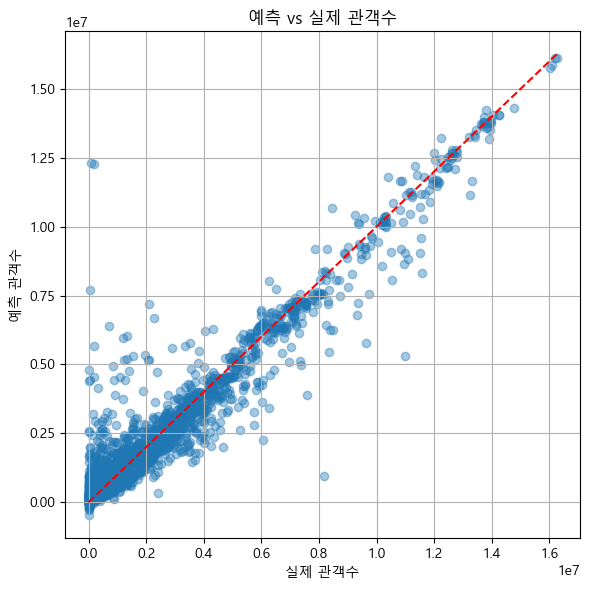

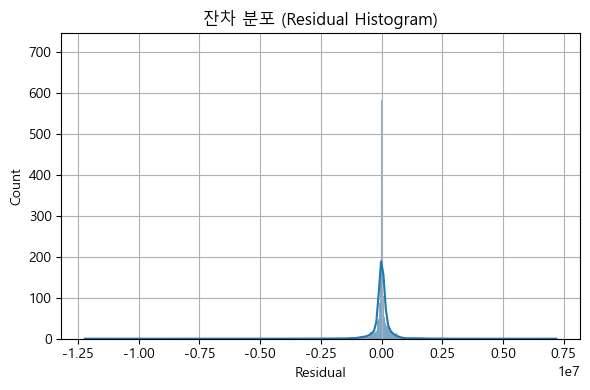


오차 큰 영화 Top 10


실제 관객수        예측 관객수         예측 오차
4344     84184.0  1.230696e+07 -1.222277e+07
1079    182934.0  1.228077e+07 -1.209783e+07
1061     39219.0  7.698750e+06 -7.659531e+06
1168   8168984.0  9.617957e+05  7.207188e+06
4012  10992805.0  5.304189e+06  5.688616e+06
3481    709323.0  6.385303e+06 -5.675980e+06
1760    185970.0  5.651437e+06 -5.465467e+06
1915   2106474.0  7.188915e+06 -5.082441e+06
1691     24616.0  4.807026e+06 -4.782410e+06
4941   1209187.0  5.970652e+06 -4.761465e+06

In [5]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import platform

if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False

# 1. K-Fold 교차검증 (RMSE 기준)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores = cross_val_score(voting_reg, X, y, scoring="neg_mean_squared_error", cv=kf)
rmse_scores = np.sqrt(-neg_mse_scores)

print(f"[K-Fold Cross Validation]")
print(f"RMSE 평균: {rmse_scores.mean():,.2f}")
print(f"RMSE 표준편차: {rmse_scores.std():,.2f}\n")

# 2. 예측값 vs 실제값 산점도
y_pred = voting_reg.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제 관객수")
plt.ylabel("예측 관객수")
plt.title("예측 vs 실제 관객수")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 잔차 분석
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("잔차 분포 (Residual Histogram)")
plt.xlabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 오차 큰 영화 TOP 10
# 잔차 계산
residuals = y_test - y_pred
errors = np.abs(residuals)

# 인덱스 리셋
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred).reset_index(drop=True)
residuals_reset = y_test_reset - y_pred_reset

# 오차 큰 TOP 10
top_errors_idx = errors.reset_index(drop=True).sort_values(ascending=False).index[:10]
worst_samples = pd.DataFrame({
    "실제 관객수": y_test_reset.loc[top_errors_idx],
    "예측 관객수": y_pred_reset.loc[top_errors_idx],
    "예측 오차": residuals_reset.loc[top_errors_idx]
})
print("\n오차 큰 영화 Top 10")
display(worst_samples)

### 오차에 해당하는 Top 10 영화 확인 ###

In [6]:
# 1. 오차 및 인덱스 계산
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred).reset_index(drop=True)
residuals_reset = y_test_reset - y_pred_reset
errors = np.abs(residuals_reset)
top_errors_idx = errors.sort_values(ascending=False).index[:10]

# 2. 오차 테이블 생성
worst_samples = pd.DataFrame({
    "실제 관객수": y_test_reset.loc[top_errors_idx],
    "예측 관객수": y_pred_reset.loc[top_errors_idx],
    "예측 오차": residuals_reset.loc[top_errors_idx]
})

# 3. 영화 정보 병합
df_meta = pd.read_csv("Director_actor_encoding.csv")
df_meta_reset = df_meta.reset_index(drop=True)

if "movieNm" in df_meta.columns and "openDt" in df_meta.columns:
    movie_info = df_meta_reset.loc[top_errors_idx, ['movieNm', 'openDt']]
    detailed_worst_samples = pd.concat([movie_info.reset_index(drop=True), worst_samples.reset_index(drop=True)], axis=1)
else:
    detailed_worst_samples = worst_samples.copy()

# 4. 표 출력
from IPython.display import display
display(detailed_worst_samples)


C:\Users\user\AppData\Local\Temp\ipykernel_16788\3687890696.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv("Director_actor_encoding.csv")


movieNm      openDt      실제 관객수        예측 관객수         예측 오차
0  무서운 이야기 3 : 화성에서 온 소녀  2016-06-01     84184.0  1.230696e+07 -1.222277e+07
1         탐정 홍길동: 사라진 마을  2016-05-04    182934.0  1.228077e+07 -1.209783e+07
2                     간신  2015-05-21     39219.0  7.698750e+06 -7.659531e+06
3              나의 절친 악당들  2015-06-25   8168984.0  9.617957e+05  7.207188e+06
4                   신데렐라  2015-03-19  10992805.0  5.304189e+06  5.688616e+06
5                     터널  2016-08-10    709323.0  6.385303e+06 -5.675980e+06
6                 검은 사제들  2015-11-05    185970.0  5.651437e+06 -5.465467e+06
7                   살인의뢰  2015-03-12   2106474.0  7.188915e+06 -5.082441e+06
8                   모데카이  2015-02-18     24616.0  4.807026e+06 -4.782410e+06
9                    마스터  2016-12-21   1209187.0  5.970652e+06 -4.761465e+06